In [ ]:
from sentence_transformers import SentenceTransformer, util
from LexRank import degree_centrality_scores
from tqdm import tqdm
import nltk
import pandas as pd
import numpy as np
import torch
import pickle
import os

In [ ]:
model_path='/data/models/iii/'

In [ ]:
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/polish.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv(f'{model_path}iii.csv', index_col=0, na_filter=False)

In [ ]:
tfidf_vectorizer = pickle.load(open(f'{model_path}tfidf-vectorizer-iii.pkl', "rb"))
len_coef_popt = pickle.load(open(f'{model_path}tfidf-coef-popt.pkl', "rb"))

def len_coef(len, a,b,c,d):
    return a*np.power(b*len,c)+d

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
model = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')

In [ ]:
top_count = 3

def tf_idf_scores(sentences, embeddings):
    tf_idf = tfidf_vectorizer.transform(sentences)
    
    sums = tf_idf.sum(axis=1).A1
    counts = len_coef(tf_idf.getnnz(axis=1), *len_coef_popt)
    scores = np.divide(sums, counts, out=np.zeros_like(sums), where=counts>5)
    
    i_scores = np.argsort(-scores)

    weighted = embeddings * torch.from_numpy(scores).cuda()[:,None]
    top = [embeddings[i] for i in i_scores[:top_count]]
    
    weighted = torch.div(torch.sum(weighted, axis=0), np.sum(scores))
    top = torch.mean(torch.stack(top), dim=0)
    top1 = embeddings[i_scores[0]]

    return weighted, top, top1

def lexrank_scores(embeddings):
    cos_scores = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()
    
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)
    
    if np.any(np.isinf(centrality_scores)) or np.any(np.isnan(centrality_scores)):
        raise Exception()
    
    weighted = embeddings * torch.from_numpy(centrality_scores).cuda()[:,None]

    i_scores = np.argsort(-centrality_scores)

    top = [embeddings[i] for i in i_scores[:top_count] if centrality_scores[i] >= 1.0]

    if len(top) == 0:
        top = [embeddings[i] for i in i_scores[:top_count]]
    
    weighted = torch.div(torch.sum(weighted, axis=0), np.sum(centrality_scores))
    top = torch.mean(torch.stack(top), dim=0)
    top1 = embeddings[i_scores[0]]

    return weighted, top, top1

In [ ]:
def embed_doc(doc):
    sentences = [sentence for sentence in tokenizer.tokenize(doc) if len(sentence) > 20]

    if len(sentences) == 0:
        fallback = model.encode(doc, convert_to_tensor=True)
        return (fallback,) * 6

    embeddings = model.encode(sentences, convert_to_tensor=True)

    embeddings_tfidf = tf_idf_scores(sentences, embeddings)
    try:
        embeddings_lexrank = lexrank_scores(embeddings)
    except Exception as ex:
        fallback = model.encode(' '.join(sentences), convert_to_tensor=True)
        embeddings_lexrank = (fallback,) * 3

    return (*embeddings_tfidf, *embeddings_lexrank)
  
def save_embeddings(emb, kad, name):
    emb_np = np.asarray([x.cpu().numpy() for x in emb])

    filename = f'{model_path}{kad}/{name}.pkl' 

    os.makedirs(os.path.dirname(filename), exist_ok=True)

    pickle.dump(emb_np, open(filename, "wb"))

In [ ]:
for kad, group in df.groupby(by="kad"):
    embeddings = list(zip(*[embed_doc(doc) for doc in tqdm(group.text.to_list(), position=0, leave=True)]))

    print(' saving kad', kad)
    save_embeddings(embeddings[0], kad, 'tfidf-weighted')
    save_embeddings(embeddings[1], kad, f'tfidf-top{top_count}')
    save_embeddings(embeddings[2], kad, 'tfidf-top1')
    save_embeddings(embeddings[3], kad, 'lexrank-weighted')
    save_embeddings(embeddings[4], kad, f'lexrank-top{top_count}')
    save_embeddings(embeddings[5], kad, 'lexrank-top1')

100%|██████████| 44873/44873 [1:04:25<00:00, 11.61it/s]


 saving kad 8


# Sentence coef

In [ ]:
from scipy.optimize import curve_fit
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt

In [ ]:
def tfidf_scores(doc):
    sentences = [sentence for sentence in tokenizer.tokenize(doc) if len(sentence) > 20]

    tf_idf = tfidf_vectorizer.transform(sentences)

    sums = tf_idf.sum(axis=1).A1
    counts = tf_idf.getnnz(axis=1)

    return [x for x in zip(counts, sums) if x[0] > 0]

In [ ]:
total = 291415

with Pool(cpu_count()) as p:
    result = [x for y in list(tqdm(p.imap(tfidf_scores, df.text.to_list()), total=total, position=0, leave=True)) for x in y]

100%|██████████| 291415/291415 [2:12:50<00:00, 36.56it/s]


In [ ]:
x,y = zip(*sorted(result, key=lambda r: r[0]))
x = np.asarray(x)
y = np.asarray(y)

In [ ]:
def len_coef(len, a,b,c,d):
    return a*np.power(b*len,c)+d

popt, _ = curve_fit(len_coef,  x,  y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


In [ ]:
y_norm = y / len_coef(x, *popt)

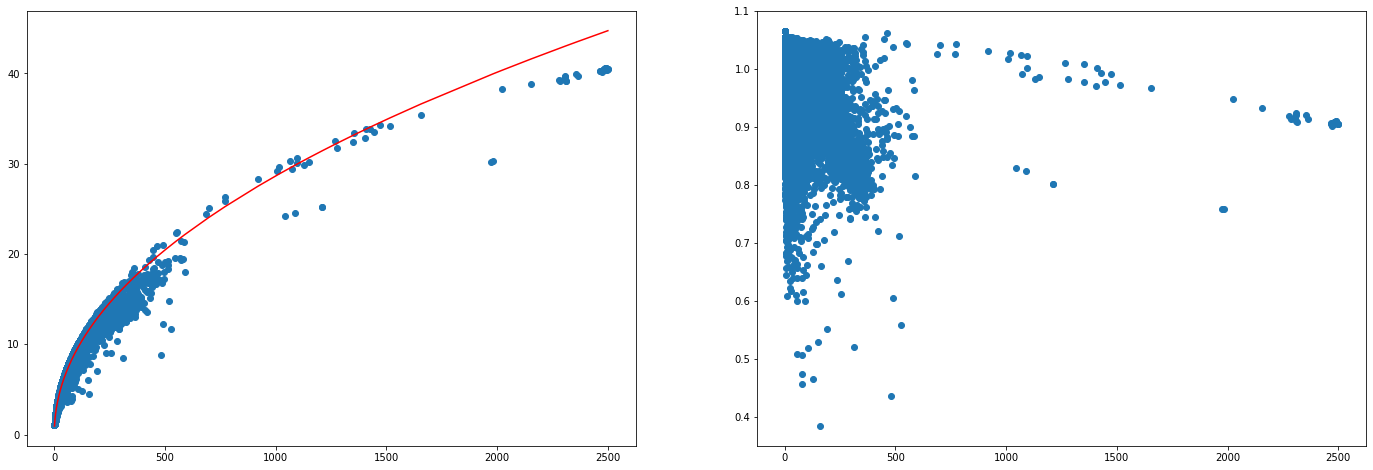

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))

ax1.scatter(x, y)
ax1.plot(x, len_coef(x, *popt), 'r-')

ax2.scatter(x, y_norm)

fig.show()

In [ ]:
popt

array([ 0.90739735,  1.22882882,  0.48556537, -0.06485649])

In [ ]:
with open(f'{model_path}tfidf-coef-popt.pkl', "wb") as f:
    pickle.dump(popt, f)

In [ ]:
with open(f'{model_path}tfidf-coef.pkl', "wb") as f:
    pickle.dump(x, f)
    pickle.dump(y, f)
    # x = pickle.load(f)
    # y = pickle.load(f)
